# Fraude en Transacciones Financieras

[![Banner.png](https://i.postimg.cc/C1t2SCwf/Banner.png)](https://postimg.cc/FdypxLd9)

## Introducción

Este notebook se enfoca en la extracción, transformación y carga (ETL) de datos de transacciones financieras para prepararlos para el análisis posterior. 

**Las tareas principales incluyen:**

Extracción: Obtener datos de una fuente externa, como una base de datos o API.
Transformación: Limpiar, formatear y transformar los datos para que sean consistentes y adecuados para el análisis.
Carga: Almacenar los datos transformados en un formato adecuado para su posterior análisis, como una base de datos o un archivo CSV.
Objetivos:

Preparar un conjunto de datos limpio y consistente para el análisis de fraude en transacciones financieras.
Garantizar la calidad y confiabilidad de los datos para obtener resultados precisos en el análisis.
Facilitar el acceso y la manipulación de los datos para futuros análisis.

### Instalaremos paquetes y librerías necesarias para descargar, trabajar los DataSets para cumplir con nuestro MVP descrito en nuestro README.md

In [1]:
# Importo librerías y paquetes necesarios
import numpy as np
import pandas as pd
import zipfile
import os
import json
import requests
import ssl
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from requests.packages.urllib3.poolmanager import PoolManager


### Trato advertencias

In [2]:
# Deshabilito advertencias de solicitudes inseguras.
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

### Llamaré a los archivos con los que trabajaremos.

In [3]:
# Rutas a los archivos ZIP y el endpoint de la API
credit_card_zip_path = r"C:\\Users\Esteban García\\OneDrive\\Escritorio\\LABs\\Datasets para Trabajar NoCountry\\DataFrames\\Credit Card Transactions Fraud Detection Dataset.zip"
ecommerce_zip_path = r"C:\\Users\\Esteban García\\OneDrive\\Escritorio\\LABs\\Datasets para Trabajar NoCountry\\DataFrames\\Fraudulent E-commerce Transactions.zip"

# Endpoint de la API del BCRA (ajustar según la documentación)
bcra_api_url = "https://api.bcra.gob.ar/estadisticas/v2.0/PrincipalesVariables"

### Establezco la ruta donde guardaré los df y *.csv

In [4]:
output_dir = r"C:\\Users\\Esteban García\\OneDrive\\Escritorio\\LABs\\Datasets para Trabajar NoCountry\\DataFrames\\DF Procesados"

### Defino la función para explorar los documentos

In [5]:
# Función para explorar y analizar los archivos *.zip

def list_files_in_zip(zip_path):
    """Listo los archivos dentro de un archivo ZIP."""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        return zip_ref.namelist()


def extract_and_read_zip(zip_path, file_name):
    """Extraigo los archivos ZIP y leo los datasets."""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("temp_dataset")
        file_path = os.path.join("temp_dataset", file_name)
        return pd.read_csv(file_path)

### Verifico que la extracción de los archivos fue existosa.

In [6]:
# Verifico los nombres de los archivos dentro de los ZIPs
credit_card_files = list_files_in_zip(credit_card_zip_path)
ecommerce_files = list_files_in_zip(ecommerce_zip_path)

# Verifico la lectura correcta de los archivos
credit_card_file_name = next((file for file in credit_card_files if file.endswith('.csv')), None)
ecommerce_file_name = next((file for file in ecommerce_files if file.endswith('.csv')), None)

if credit_card_file_name:
    credit_card_df = extract_and_read_zip(credit_card_zip_path, credit_card_file_name)
else:
    print("No se encontró un archivo CSV en el ZIP de tarjetas de crédito.")

if ecommerce_file_name:
    ecommerce_df = extract_and_read_zip(ecommerce_zip_path, ecommerce_file_name)
else:
    print("No se encontró un archivo CSV en el ZIP de comercio electrónico.")

### Consulto la APIs del BCRA

In [7]:
# Determino la URL base de la API
base_url = "https://api.bcra.gob.ar/estadisticas/v2.0/"

# Establezco el endpoint para obtener principales variables
variables_url = base_url + "principalesvariables"

# Solicito los datos de principales variables
response = requests.get(variables_url, verify=False)
if response.status_code == 200:
    variables = response.json()['results']
else:
    print("Error al obtener principales variables:", response.status_code)

# Creo un DataFrame con las principales variables
bcra_df = pd.DataFrame(variables)

# Muestro las primeras filas del DataFrame
print(bcra_df.head())

# Guardar el DataFrame en un archivo CSV
output_dir = r"C:\\Users\\Esteban García\\OneDrive\\Escritorio\\LABs\\Datasets para Trabajar NoCountry\\DataFrames\\DF Procesados"
bcra_df.to_csv(output_dir + "principales_variables.csv", index=False)

# Función para obtener datos de una variable específica
def obtener_datos_variable(id_variable, desde, hasta):
    datos_url = f"{base_url}datosvariable/{id_variable}/{desde}/{hasta}"
    response = requests.get(datos_url, verify=False)
    if response.status_code == 200:
        return response.json()['results']
    else:
        print("Error al obtener datos de la variable:", response.status_code)
        return []

# Establezco el rango de fechas para el año 2024
id_variable = 1  # ID de la variable a consultar
desde = "2024-01-01"  # Fecha de inicio del rango
hasta = "2024-12-31"  # Fecha de fin del rango

datos_variable = obtener_datos_variable(id_variable, desde, hasta)

# Creo el DataFrame con los datos de la variable
bcra_df = pd.DataFrame(datos_variable)

# Mostrar las primeras filas del DataFrame de datos de la variable
print(bcra_df.head())

# Guardar el DataFrame en un archivo CSV
bcra_df.to_csv(output_dir + "datos_variable.csv", index=False)



   idVariable  cdSerie                                        descripcion  \
0           1      246  Reservas Internacionales del BCRA (en millones...   
1           4     7927  Tipo de Cambio Minorista ($ por USD) Comunicac...   
2           5      272  Tipo de Cambio Mayorista ($ por USD) Comunicac...   
3           6     7935             Tasa de Política Monetaria (en % n.a.)   
4           7     1222     BADLAR en pesos de bancos privados (en % n.a.)   

        fecha     valor  
0  2024-07-16  27623.00  
1  2024-07-18    962.11  
2  2024-07-18    924.75  
3  2024-07-18     40.00  
4  2024-07-17     37.50  
   idVariable       fecha    valor
0           1  2024-01-02  23470.0
1           1  2024-01-03  23677.0
2           1  2024-01-04  23835.0
3           1  2024-01-05  24119.0
4           1  2024-01-08  23233.0


### Visualizo los df para ver su contenido para tener un primer acercamiento al contenido, visualizarlo y entender los pasos a seguir.

In [8]:
ecommerce_df

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,c8604004-2f4c-42ce-a1c4-cd2bebca79bb,f8a534ad-0458-465e-a85b-3ad2cdf391bc,208.48,2024-01-12 23:39:55,PayPal,health & beauty,2,29,North Laurafort,desktop,27.245.104.92,USNV Griffin\nFPO AA 52700,USNV Griffin\nFPO AA 52700,0,149,23
1472948,fff0df19-fd4a-42a5-bc42-64bb7b02edb0,f2ef2239-d9b9-40d0-9993-4b8f305d5a7b,231.57,2024-03-27 04:31:45,credit card,clothing,2,32,Burnsville,tablet,203.54.50.163,"478 John Square Apt. 235\nMillerhaven, GA 68797","478 John Square Apt. 235\nMillerhaven, GA 68797",0,132,4
1472949,9e79012f-e00b-47d1-8700-0c302db20d3e,fa5b9a25-9606-478a-8abe-ef20bbb3980f,101.80,2024-01-31 23:51:42,bank transfer,electronics,4,36,Garciafort,mobile,51.241.30.149,"351 Frazier Radial Apt. 989\nPort Charles, OH ...","182 House Island Suite 198\nEast Scott, FM 84301",0,98,23
1472950,917066b1-4dfb-4472-b3f0-292663c45d21,04524272-e14f-460b-bc70-5316bd28463d,61.80,2024-01-12 16:21:32,bank transfer,electronics,5,34,Lake Josephberg,desktop,210.67.203.4,"27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...","27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...",0,191,16


In [9]:
credit_card_df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,...,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,...,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,...,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,...,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [10]:
bcra_df

,idVariable,fecha,valor
0,1,2024-01-02,23470.0
1,1,2024-01-03,23677.0
2,1,2024-01-04,23835.0
3,1,2024-01-05,24119.0
4,1,2024-01-08,23233.0
...,...,...,...
125,1,2024-07-10,28098.0
126,1,2024-07-11,28235.0
127,1,2024-07-12,28282.0
128,1,2024-07-15,28177.0


### Al haber una reducción de personal a última hora, elegimos trabajar con el DataFrame llamado ecommerce_df

In [11]:
ecommerce_df

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,c8604004-2f4c-42ce-a1c4-cd2bebca79bb,f8a534ad-0458-465e-a85b-3ad2cdf391bc,208.48,2024-01-12 23:39:55,PayPal,health & beauty,2,29,North Laurafort,desktop,27.245.104.92,USNV Griffin\nFPO AA 52700,USNV Griffin\nFPO AA 52700,0,149,23
1472948,fff0df19-fd4a-42a5-bc42-64bb7b02edb0,f2ef2239-d9b9-40d0-9993-4b8f305d5a7b,231.57,2024-03-27 04:31:45,credit card,clothing,2,32,Burnsville,tablet,203.54.50.163,"478 John Square Apt. 235\nMillerhaven, GA 68797","478 John Square Apt. 235\nMillerhaven, GA 68797",0,132,4
1472949,9e79012f-e00b-47d1-8700-0c302db20d3e,fa5b9a25-9606-478a-8abe-ef20bbb3980f,101.80,2024-01-31 23:51:42,bank transfer,electronics,4,36,Garciafort,mobile,51.241.30.149,"351 Frazier Radial Apt. 989\nPort Charles, OH ...","182 House Island Suite 198\nEast Scott, FM 84301",0,98,23
1472950,917066b1-4dfb-4472-b3f0-292663c45d21,04524272-e14f-460b-bc70-5316bd28463d,61.80,2024-01-12 16:21:32,bank transfer,electronics,5,34,Lake Josephberg,desktop,210.67.203.4,"27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...","27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...",0,191,16


### Análisis exploratorio de fraudes en e-commerce_df

In [12]:
print(ecommerce_df.columns)

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date', 'Payment Method', 'Product Category', 'Quantity',
       'Customer Age', 'Customer Location', 'Device Used', 'IP Address',
       'Shipping Address', 'Billing Address', 'Is Fraudulent',
       'Account Age Days', 'Transaction Hour'],
      dtype='object')


In [13]:
# Verifique los tipos de datos en su DataFrame (opcional)
print(ecommerce_df.dtypes)  # Data Analyst: Comentar esta línea si ya conoces los tipos

Transaction ID         object
Customer ID            object
Transaction Amount    float64
Transaction Date       object
Payment Method         object
Product Category       object
Quantity                int64
Customer Age            int64
Customer Location      object
Device Used            object
IP Address             object
Shipping Address       object
Billing Address        object
Is Fraudulent           int64
Account Age Days        int64
Transaction Hour        int64
dtype: object


### Modificaré la columna 'Transaction Date' en dos columnas una que contenga la fecha y la hora que contenga la hora, ambas en fomato datetime.

In [14]:
# Aquí tengo que dividir la columna en fecha y hora y transformarla a tipo Datetime

In [15]:
ecommerce_df

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,c8604004-2f4c-42ce-a1c4-cd2bebca79bb,f8a534ad-0458-465e-a85b-3ad2cdf391bc,208.48,2024-01-12 23:39:55,PayPal,health & beauty,2,29,North Laurafort,desktop,27.245.104.92,USNV Griffin\nFPO AA 52700,USNV Griffin\nFPO AA 52700,0,149,23
1472948,fff0df19-fd4a-42a5-bc42-64bb7b02edb0,f2ef2239-d9b9-40d0-9993-4b8f305d5a7b,231.57,2024-03-27 04:31:45,credit card,clothing,2,32,Burnsville,tablet,203.54.50.163,"478 John Square Apt. 235\nMillerhaven, GA 68797","478 John Square Apt. 235\nMillerhaven, GA 68797",0,132,4
1472949,9e79012f-e00b-47d1-8700-0c302db20d3e,fa5b9a25-9606-478a-8abe-ef20bbb3980f,101.80,2024-01-31 23:51:42,bank transfer,electronics,4,36,Garciafort,mobile,51.241.30.149,"351 Frazier Radial Apt. 989\nPort Charles, OH ...","182 House Island Suite 198\nEast Scott, FM 84301",0,98,23
1472950,917066b1-4dfb-4472-b3f0-292663c45d21,04524272-e14f-460b-bc70-5316bd28463d,61.80,2024-01-12 16:21:32,bank transfer,electronics,5,34,Lake Josephberg,desktop,210.67.203.4,"27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...","27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...",0,191,16


AttributeError: 'DatetimeProperties' object has no attribute 'weekday_name'

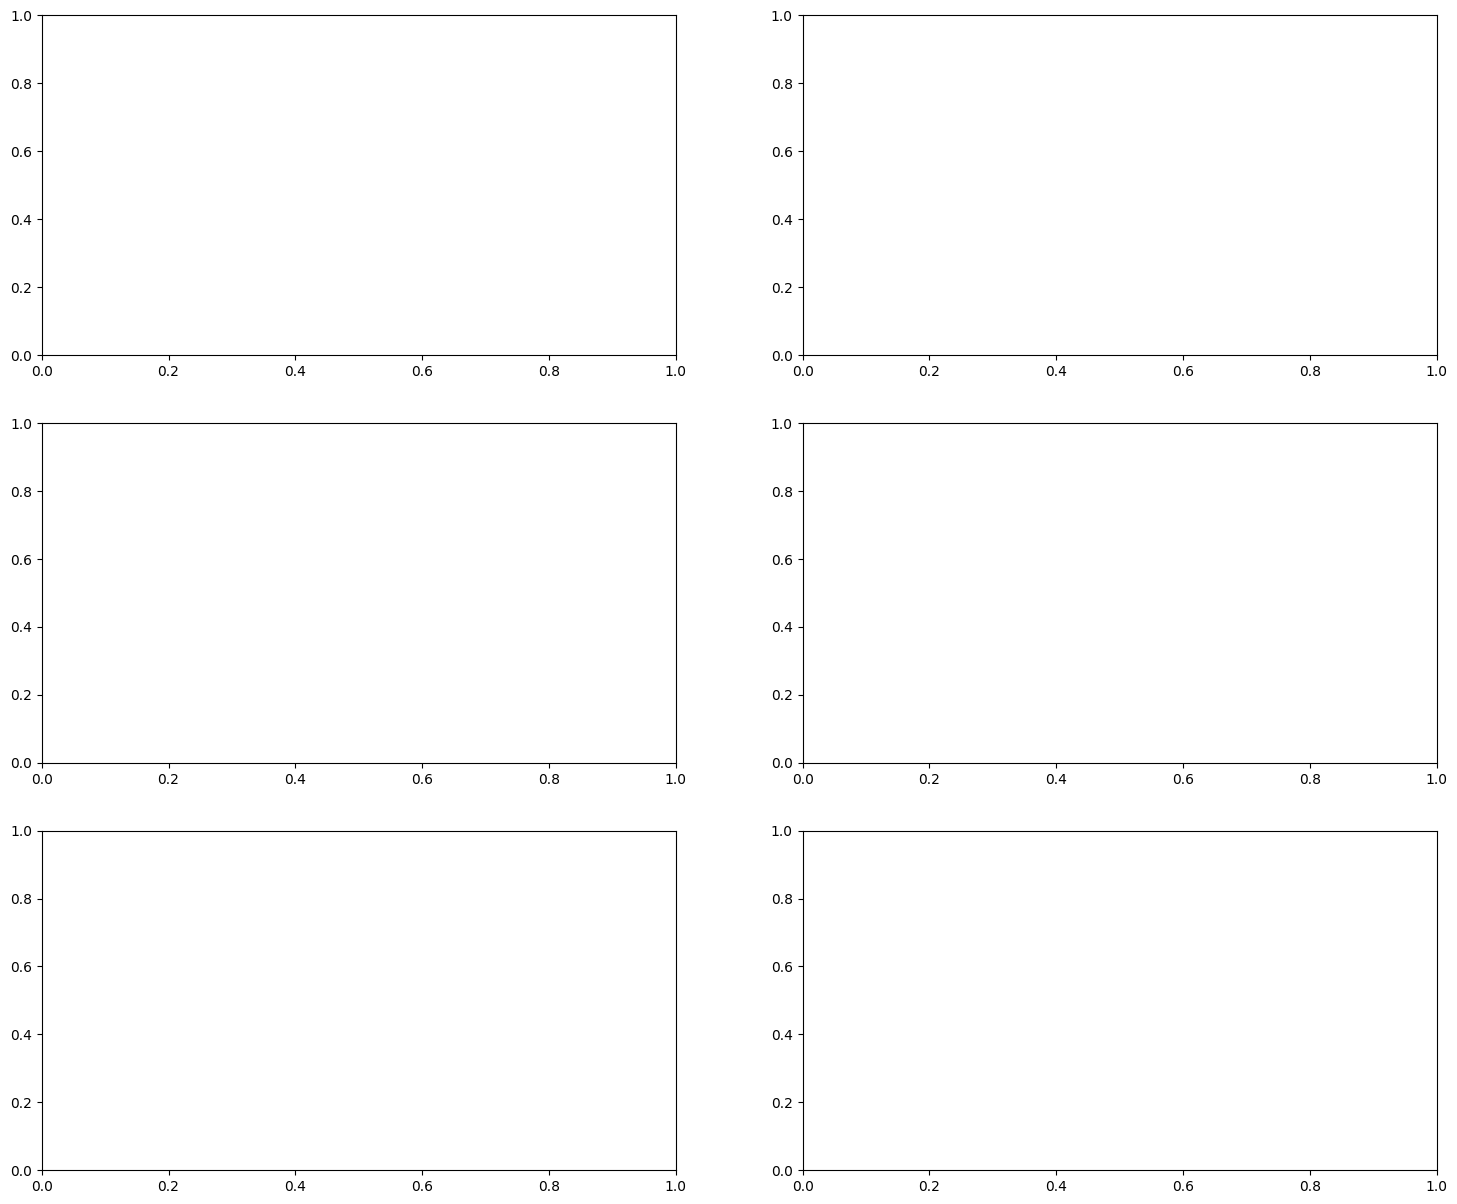

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de datos de ejemplo (reemplace con la carga real de sus datos)
df = ecommerce_df

# Conversión de 'Transaction Date' a formato datetime
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])

# Filtrado de transacciones fraudulentas
fraude_df = df[df['Is Fraudulent'] == 1]

# Verificación de la columna 'Payment Method'
columna_pago = 'Payment Method' if 'Payment Method' in fraude_df.columns else 'Gender'

# Creación de subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# 1. Día de mayor frecuencia de fraude
fraude_df['Día de la Semana'] = fraude_df['Transaction Date'].dt.weekday_name()
sns.countplot(x='Día de la Semana', hue='Día de la Semana', data=fraude_df, ax=axes[0, 0], palette="viridis", legend=False)
axes[0, 0].set_title('Día más frecuente de Fraude')
axes[0, 0].set_xlabel('Día de la Semana')
axes[0, 0].set_ylabel('Conteo')

# 2. Hora de mayor frecuencia de fraude
fraude_df['Hora de la Transacción'] = fraude_df['Transaction Date'].dt.hour
sns.countplot(x='Hora de la Transacción', hue='Hora de la Transacción', data=fraude_df, ax=axes[0, 1], palette="viridis", legend=False)
axes[0, 1].set_title('Hora más frecuente de Fraude')
axes[0, 1].set_xlabel('Hora de la Transacción')
axes[0, 1].set_ylabel('Conteo')

# 3. Método de pago más frecuente en el fraude
sns.countplot(x=columna_pago, data=fraude_df, ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title('Método de Pago más Frecuente en Fraude')
axes[1, 0].set_xlabel(columna_pago)
axes[1, 0].set_ylabel('Conteo')

# 4. Categoría de producto más afectada
if 'Product Category' in fraude_df.columns:
  sns.countplot(x='Product Category', data=fraude_df, ax=axes[1, 1], palette="viridis")
  axes[1, 1].set_title('Categoría de Producto Más Afectada')
  axes[1, 1].set_xlabel('Categoría de Producto')
  axes[1, 1].set_ylabel('Conteo')
else:
  print("No se encontró la columna 'Product Category'. Se omite esta visualización.")

# 5. Dispositivo más utilizado en el fraude
sns.countplot(x='Device Used', data=fraude_df, ax=axes[2, 0], palette="viridis")
axes[2, 0].set_title('Dispositivo más Utilizado en el Fraude')
axes[2, 0].set_xlabel('Dispositivo Utilizado')
axes[2, 0].set_ylabel('Conteo')

# 6. Distribución del fraude por edad del cliente
if 'Customer Age' in fraude_df.columns:
  sns.histplot(fraude_df['Customer Age'], kde=True, ax=axes[2, 1], color='blue')
  axes[2, 1].set_title('Distribución de la Edad del Cliente en Transacciones Fraudulentas')
  axes[2, 1].set_xlabel('Edad del Cliente')
  axes[2, 1].set_ylabel('Frecuencia')
else:
  print("No se encontró la columna 'Customer Age'. Se omite esta visualización.")

# 7. Análisis de ubicación (por ahora no se incluye una gráfica)
print("Las visualizaciones de comparación de direcciones requieren un análisis adicional. Se omite por ahora.")

# 8. Antigüedad de la cuenta y fraude
if 'Account Age Days' in fraude_df.columns:
    # Aquí se debe incluir el código para analizar la relación entre la antigüedad de la cuenta y el fraude
    print("Análisis de antigüedad de la cuenta en progreso...")
    # ...
else:
    print("No se encontró la columna 'Account Age Days'. Se omite esta visualización.")

In [ ]:
import pandas as pd

# Suponiendo que ya tienes cargado tu DataFrame llamado ecommerce_df

# Obtener una muestra del 10% del DataFrame
sample_df = ecommerce_df.sample(frac=0.1)

# Especificar la ruta y nombre del archivo donde se guardará la muestra
file_path = "C:\\Users\\Esteban García\\OneDrive\\Escritorio\\LABs\\No Country\\ecommerce.csv"

# Guardar la muestra en un archivo CSV en la carpeta específica
sample_df.to_csv(file_path, index=False)

print("Muestra del 10% guardada exitosamente en:", file_path)